In [5]:
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets, model_selection, preprocessing, svm, metrics, decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(0) # set random seed so everyone gets same results

In [6]:
final = pd.read_csv("VAERS_final.csv")
final.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,Pain,Pyrexia,Rash,Throat.tightness,Thrombosis,Tinnitus,Tremor,Urticaria,Vomiting,labels
0,916600.0,1/1/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,False,False,False,False,False,False,False,False,False,0
1,916601.0,1/1/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,False,False,False,False,False,False,False,False,False,1
2,916602.0,1/1/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,True,False,False,False,False,False,False,False,False,1
3,916603.0,1/1/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,False,False,False,False,False,False,False,False,False,0
4,916604.0,1/1/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,False,False,False,False,False,False,False,False,False,0


In [7]:
X = final[["AGE_YRS", "SEX", "OTHER_MEDS","HISTORY","ALLERGIES","VAX_MANU","VAX_DOSE_SERIES"]]
y = final['labels']

In [8]:
X["AGE_YRS"] = X["AGE_YRS"].replace(np.NaN, X["AGE_YRS"].mean()) #replacing missing age values with mean of the column to prevent data loss

<ipython-input-8-6d5929280b8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["AGE_YRS"] = X["AGE_YRS"].replace(np.NaN, X["AGE_YRS"].mean()) #replacing missing age values with mean of the column to prevent data loss


In [9]:
# List of the column names with features that should be ordinal encoded
ordinal_features = ['SEX','VAX_MANU']

# Ordinal encode all of these features
ordinal = sklearn.preprocessing.OrdinalEncoder()
X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])

<ipython-input-9-714d02f7ea84>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])
C:\Users\gkong\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)
ss = preprocessing.StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

rfc_predict=rfc.predict(X_test)

In [10]:
print("Accuracy:",metrics.accuracy_score(y_test, rfc_predict))
print("Accuracy:",metrics.recall_score(y_test, rfc_predict))

Accuracy: 0.693050475493782
Accuracy: 0.2540733197556008


In [11]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring = "recall")

In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

In [ ]:
plt.figure()
metrics.plot_confusion_matrix(rfc, X_test, y_test)
plt.show()

In [12]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

In [13]:
# Random search of parameters

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, scoring="recall", n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.0min finished


{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 460}


In [11]:
rfc2 = RandomForestClassifier(n_estimators=200, max_depth=460, max_features='sqrt')
rfc2.fit(X_train, y_train)
rfc2_predict = rfc2.predict(X_test)
rfc2_cv_score = cross_val_score(rfc2, X, y, cv=10, scoring='recall')
rfc2.feature_importances_

array([0.77200853, 0.04022868, 0.02218683, 0.03887244, 0.02773007,
       0.04728452, 0.05168893])

<AxesSubplot:>

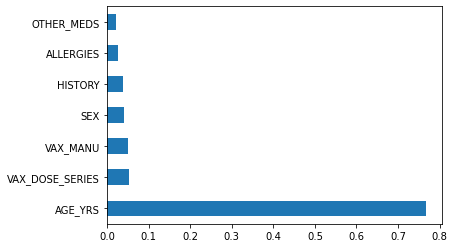

In [15]:
feat_importances = pd.Series(rfc2.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')

In [16]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc2_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc2_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc2_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc2_cv_score.mean())

=== Confusion Matrix ===
[[4236  635]
 [1444  520]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4871
           1       0.45      0.26      0.33      1964

    accuracy                           0.70      6835
   macro avg       0.60      0.57      0.57      6835
weighted avg       0.66      0.70      0.67      6835



=== All AUC Scores ===
[0.10764588 0.09758551 0.10362173 0.15191147 0.27693857 0.32930514
 0.32930514 0.34843907 0.31690141 0.3943662 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.24560201085668085


<Figure size 432x288 with 0 Axes>

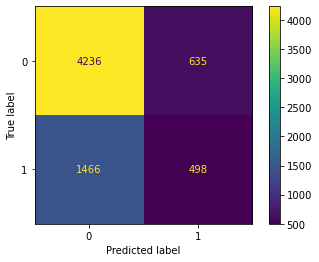

In [12]:
plt.figure()
metrics.plot_confusion_matrix(rfc2, X_test, y_test)
plt.show()